## 프로젝트 : 개선된 U-Net 모델 만들기

<img src="https://8888-w1qs711w4jqeax0t8bo2en9i5.e.aiffel-4.ainetwork.ai/view/aiffel/semantic_segmentation/img/result.gif" width="80%" height="80%">

### 실습목표
---
- 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.
- 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.
- 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.

### 학습내용
---
1. 시맨틱 세그멘테이션 데이터셋
2. 시맨틱 세그멘테이션 모델
3. 시맨틱 세그멘테이션 모델 시각화

<img src="https://8888-w1qs711w4jqeax0t8bo2en9i5.e.aiffel-4.ainetwork.ai/view/aiffel/semantic_segmentation/img/GC-5-P-UNPP.max-800x600.png" width="80%" height="80%">
<center><span style="color:#aeaeae">[KITTI 데이터셋 segmentation_rgb]</span></center>

## Step 1. KITTI 데이터셋 수집과 구축

다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습 데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.

#### 라이브러리 가져오기

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

#### Augmentation 기법을 확률적으로 적용

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

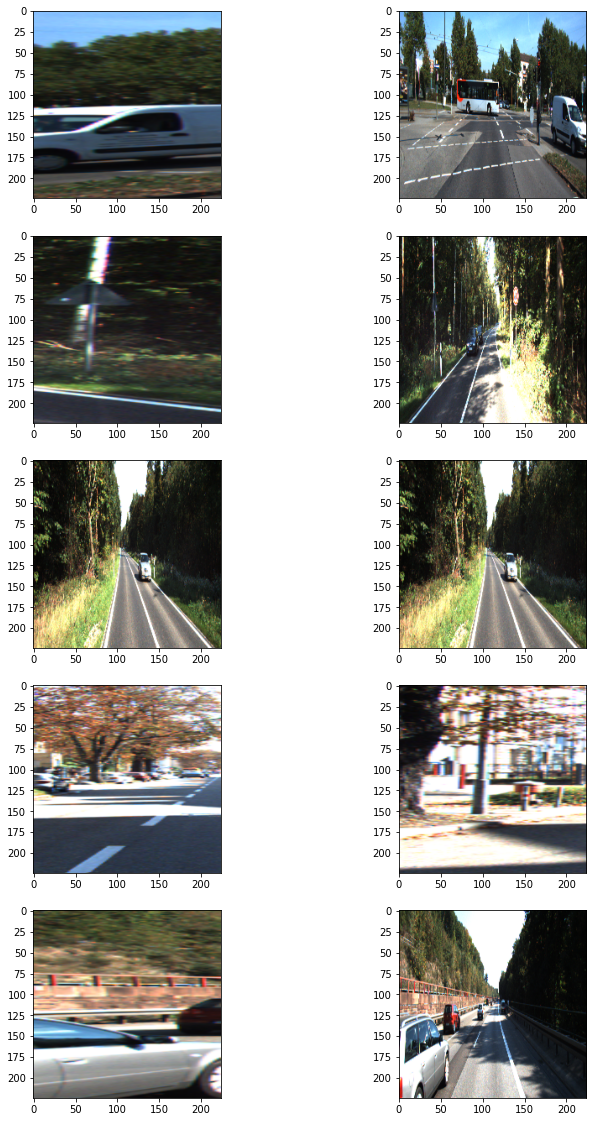

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

#### `tf.keras.utils.Sequence`를 상속받은 `generator` 형태로 데이터를 구성

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net++ 모델의 구현

U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.
그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

### 모델 구조 만들기 (U-Net 모델)

In [6]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

#### 모델 학습하기

In [7]:
# model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

# model = build_model()
# model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
# model.fit_generator(
#      generator=train_generator,
#      validation_data=test_generator,
#      steps_per_epoch=len(train_generator),
#      epochs=100,
#  )

# model.save(model_path)  #학습한 모델을 저장해 주세요.

### 모델 구조 만들기 (U-Net++ 모델)

In [8]:
def build_pp_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

  # X_,0
  conv00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv00)
  pool00 = MaxPooling2D(pool_size=(2, 2))(conv00)
  conv10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool00)
  conv10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv10)
  pool10 = MaxPooling2D(pool_size=(2, 2))(conv10)
  conv20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool10)
  conv20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv20)
  pool20 = MaxPooling2D(pool_size=(2, 2))(conv20)
  conv30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool20)
  conv30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv30)
#   drop30 = Dropout(0.5)(conv30)
  pool30 = MaxPooling2D(pool_size=(2, 2))(conv30)

  conv40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool30)  
  conv40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv40)

  # X_,1
  up01 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv10))
  merge01 = concatenate([conv00,up01], axis = 3)
  conv01 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge01)
  conv01 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv01)
  up11 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv20))
  merge11 = concatenate([conv10,up11], axis = 3)
  conv11 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge11)
  conv11 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv11)
  up21 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv30))
  merge21 = concatenate([conv20,up21], axis = 3)
  conv21 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge21)
  conv21 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv21)
  up31 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv40))
  merge31 = concatenate([conv30,up31], axis = 3)
  conv31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge31)
  conv31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv31)
  
  # X_,2
  up02 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv11))
  merge02 = concatenate([conv00,conv01,up02], axis = 3)
  conv02 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge02)
  conv02 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv02)
  up12 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv21))
  merge12 = concatenate([conv10,conv11,up12], axis = 3)
  conv12 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge12)
  conv11 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv12)
  up22 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv31))
  merge22 = concatenate([conv20,conv21,up22], axis = 3)
  conv22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge22)
  conv22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv22)
  
  # X_,3
  up03 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv12))
  merge03 = concatenate([conv00,conv01,conv02,up03], axis = 3)
  conv03 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge03)
  conv03 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv03)
  up13 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv22))
  merge13 = concatenate([conv10,conv11,conv12,up13], axis = 3)
  conv13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge13)
  conv13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv13)

  # X_,4
  up04 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv13))
  merge04 = concatenate([conv00,conv01,conv02,conv03,up04], axis = 3)
  conv04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge04)
  conv04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv04)
  conv04 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv04)     
  conv04 = Conv2D(1, 1, activation='sigmoid')(conv04)

  model = Model(inputs = inputs, outputs = conv04)
  return model

In [9]:
pp_model = build_pp_model()
pp_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp.h5'

model = build_pp_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 ) 

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 96s 2s/step - loss: 0.5139 - val_loss: 0.1736
Epoch 2/100
43/43 [==============================] - 85s 2s/step - loss: 0.1507 - val_loss: 0.1989
Epoch 3/100
43/43 [==============================] - 85s 2s/step - loss: 0.1594 - val_loss: 0.0984
Epoch 4/100
43/43 [==============================] - 85s 2s/step - loss: 0.0950 - val_loss: 0.1195
Epoch 5/100
43/43 [==============================] - 85s 2s/step - loss: 0.1004 - val_loss: 0.0884
Epoch 6/100
43/43 [==============================] - 85s 2s/step - loss: 0.0867 - val_loss: 0.1256
Epoch 7/100
43/43 [==============================] - 85s 2s/step - loss: 0.1013 - val_loss: 0.1111
Epoch 8/100
43/43 [==============================] - 85s 2s/step - loss: 0.0960 - val_loss: 0.0809
Epoch 9/100
43/43 [==============================] - 85s 2s/step - loss: 0.0759 - val_loss: 0.0827
Epoch 10/100
43/43 [==============================] - 85s 2s/step - loss: 0.0748 - val_loss: 0.0774
Epoch 11/

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

In [17]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
model_pp_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp.h5' 

model = tf.keras.models.load_model(model_path)
model_pp = tf.keras.models.load_model(model_pp_path)

In [18]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

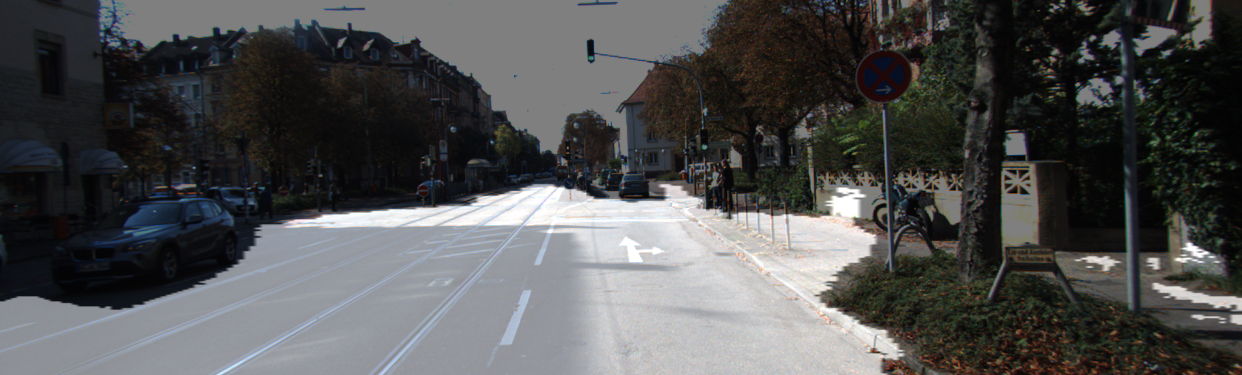

In [19]:
# U-Net 시각화 결과
i = 1
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

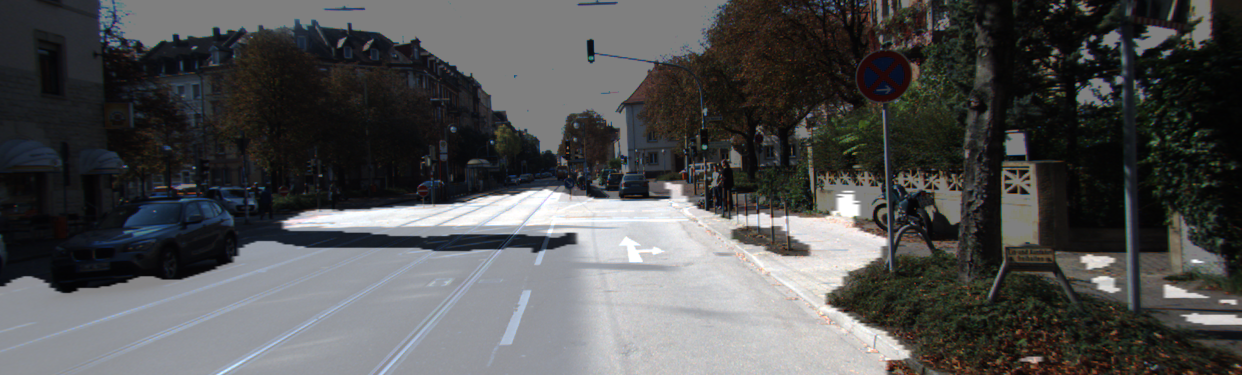

In [20]:
# U-Net++ 시각화 결과
i = 1
get_output(
     model_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [21]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [22]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [23]:
# U-Net 결과
i = 1
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.836892


0.8368918445922297

In [24]:
# U-Net++ 결과
i = 1
output, prediction, target = get_output(
     model_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.834470


0.8344701497784965

## Rubric

||**평가 문항**|**상세 기준**|
|:--------|:--------|:--------|
|**1**|U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?|KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.|
|**2**|U-Net++ 모델이 성공적으로 구현되었는가?|U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.|
|**3**|U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?|U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.|

## 회고

모델을 열심히 짠다고 짜서 좋아했는데, 안 돌아가는 상황이 발생해서 다른 분들의 예시를 참고해서 수정을 해봤지만 아직 성능이 좋진 않은 것 같아서 마음이 아팠다.